In [39]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

## Settings

In [40]:
FIG_DPI = 160
FIG_SIZE = [16, 9]

plt.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.dpi'] = FIG_DPI

sns.set()
# sns.set_palette('husl')
sns.set_style('darkgrid')

## Parameters

In [41]:
PORTALS = {
    'data.gov.uk': {
        'url': 'https://ckan.publishing.service.gov.uk/api/3',
        'theme-field': 'theme-primary'
    },
    'data.kdl.kcl.ac.uk': {
        'url': 'https://data.kdl.kcl.ac.uk/api/3',
        'theme-field': 'theme-primary'
    }
}

## Helper functions

In [42]:
def do_get(url):
    if not url:
        return None
    
    r = requests.get(url)
    
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    return r.json()

In [43]:
def get_extensions(portal):
    """Returns a dictionary of the extensions used in the portal."""
    if not portal:
        return None
    
    url = '{}/action/status_show'.format(portal)
    data = do_get(url)
    
    if not data:
        return None
    
    data = data['result']['extensions']
    
    return {
        k: 1 for k in data
    }

In [44]:
def get_tags(portal):
    """Returns a dictionary of the tags used in the portal. The tags are sorted alphabetically."""
    if not portal:
        return None
    
    url = '{}/action/package_search?facet.field=["tags"]&facet.limit=-1&facet.mincount=2'.format(portal)
    data = do_get(url)
    
    if not data:
        return None
    
    data = data['result']['facets']['tags']
    data = dict(sorted(data.items(), key=lambda t: t[0].lower()))
        
    return data

In [45]:
def get_themes(portal, theme_field):
    """Returns a dictionary of the themes used in the portal. The themes are sorted alphabetically."""
    if not portal:
        return None
    
    url = '{}/action/package_search?facet.field=["{}"]&facet.limit=-1'.format(portal, theme_field)
    data = do_get(url)
    
    if not data:
        return None
        
    data = data['result']['facets'][theme_field]
    data = dict(sorted(data.items(), key=lambda t: t[0].lower()))
        
    return data

In [46]:
def add_dict_to_df(df, data, index):
    """Adds a dictionary to a pandas dataframe."""
    return df.append(pd.DataFrame([data], index=[index]), sort=False)

In [47]:
def convert_df_to_numeric(df, columns=[], errors='ignore'):
    """Converts all the columns in the dataframe to numeric.
    If the columns argument is given, it converts only the given columns.
    By default it ignores conversion errors."""
    if columns:
        return df[columns].apply(pd.to_numeric, errors=errors)
        
    return df.apply(pd.to_numeric, errors=errors)

## Harvest data from the portals
### Extensions

In [48]:
exts_df = pd.DataFrame()

for k in PORTALS.keys():
    portal = PORTALS[k]
    
    exts = get_extensions(portal['url'])
    exts[k] = k
    
    exts_df = add_dict_to_df(exts_df, exts, k)

### Tags

In [49]:
tags_df = pd.DataFrame()

for k in PORTALS.keys():
    portal = PORTALS[k]
    
    tags = get_tags(portal['url'])
    tags[k] = k
    
    tags_df = add_dict_to_df(tags_df, tags, k)

### Themes

In [50]:
themes_df = pd.DataFrame()

for k in PORTALS.keys():
    portal = PORTALS[k]
    
    themes = get_themes(portal['url'], portal['theme-field'])
    themes[k] = k
    
    themes_df = add_dict_to_df(themes_df, themes, k)

## Prepare the data
### Extensions

In [51]:
exts_df = exts_df.transpose()
exts_df = exts_df.drop(PORTALS.keys())
exts_df = convert_df_to_numeric(exts_df)
exts_df = exts_df.sort_index()
# exts_df = exts_df.fillna(0)

### Tags

In [52]:
tags_df = tags_df.transpose()
tags_df = tags_df.drop(PORTALS.keys())
tags_df = convert_df_to_numeric(tags_df)
# tags_df = tags_df.fillna(0)

### Themes

In [53]:
themes_df = themes_df.transpose()
themes_df = themes_df.drop(PORTALS.keys())
themes_df = convert_df_to_numeric(themes_df)
# themes_df = themes_df.fillna(0)

## Visualise
### Extensions

In [54]:
exts_df.head()

,data.gov.uk,data.kdl.kcl.ac.uk
ckan_harvester,1.0,NaN
csw_harvester,1.0,NaN
datagovsg_s3_resources,1.0,NaN
datagovuk,1.0,NaN
datagovuk_publisher_form,1.0,NaN


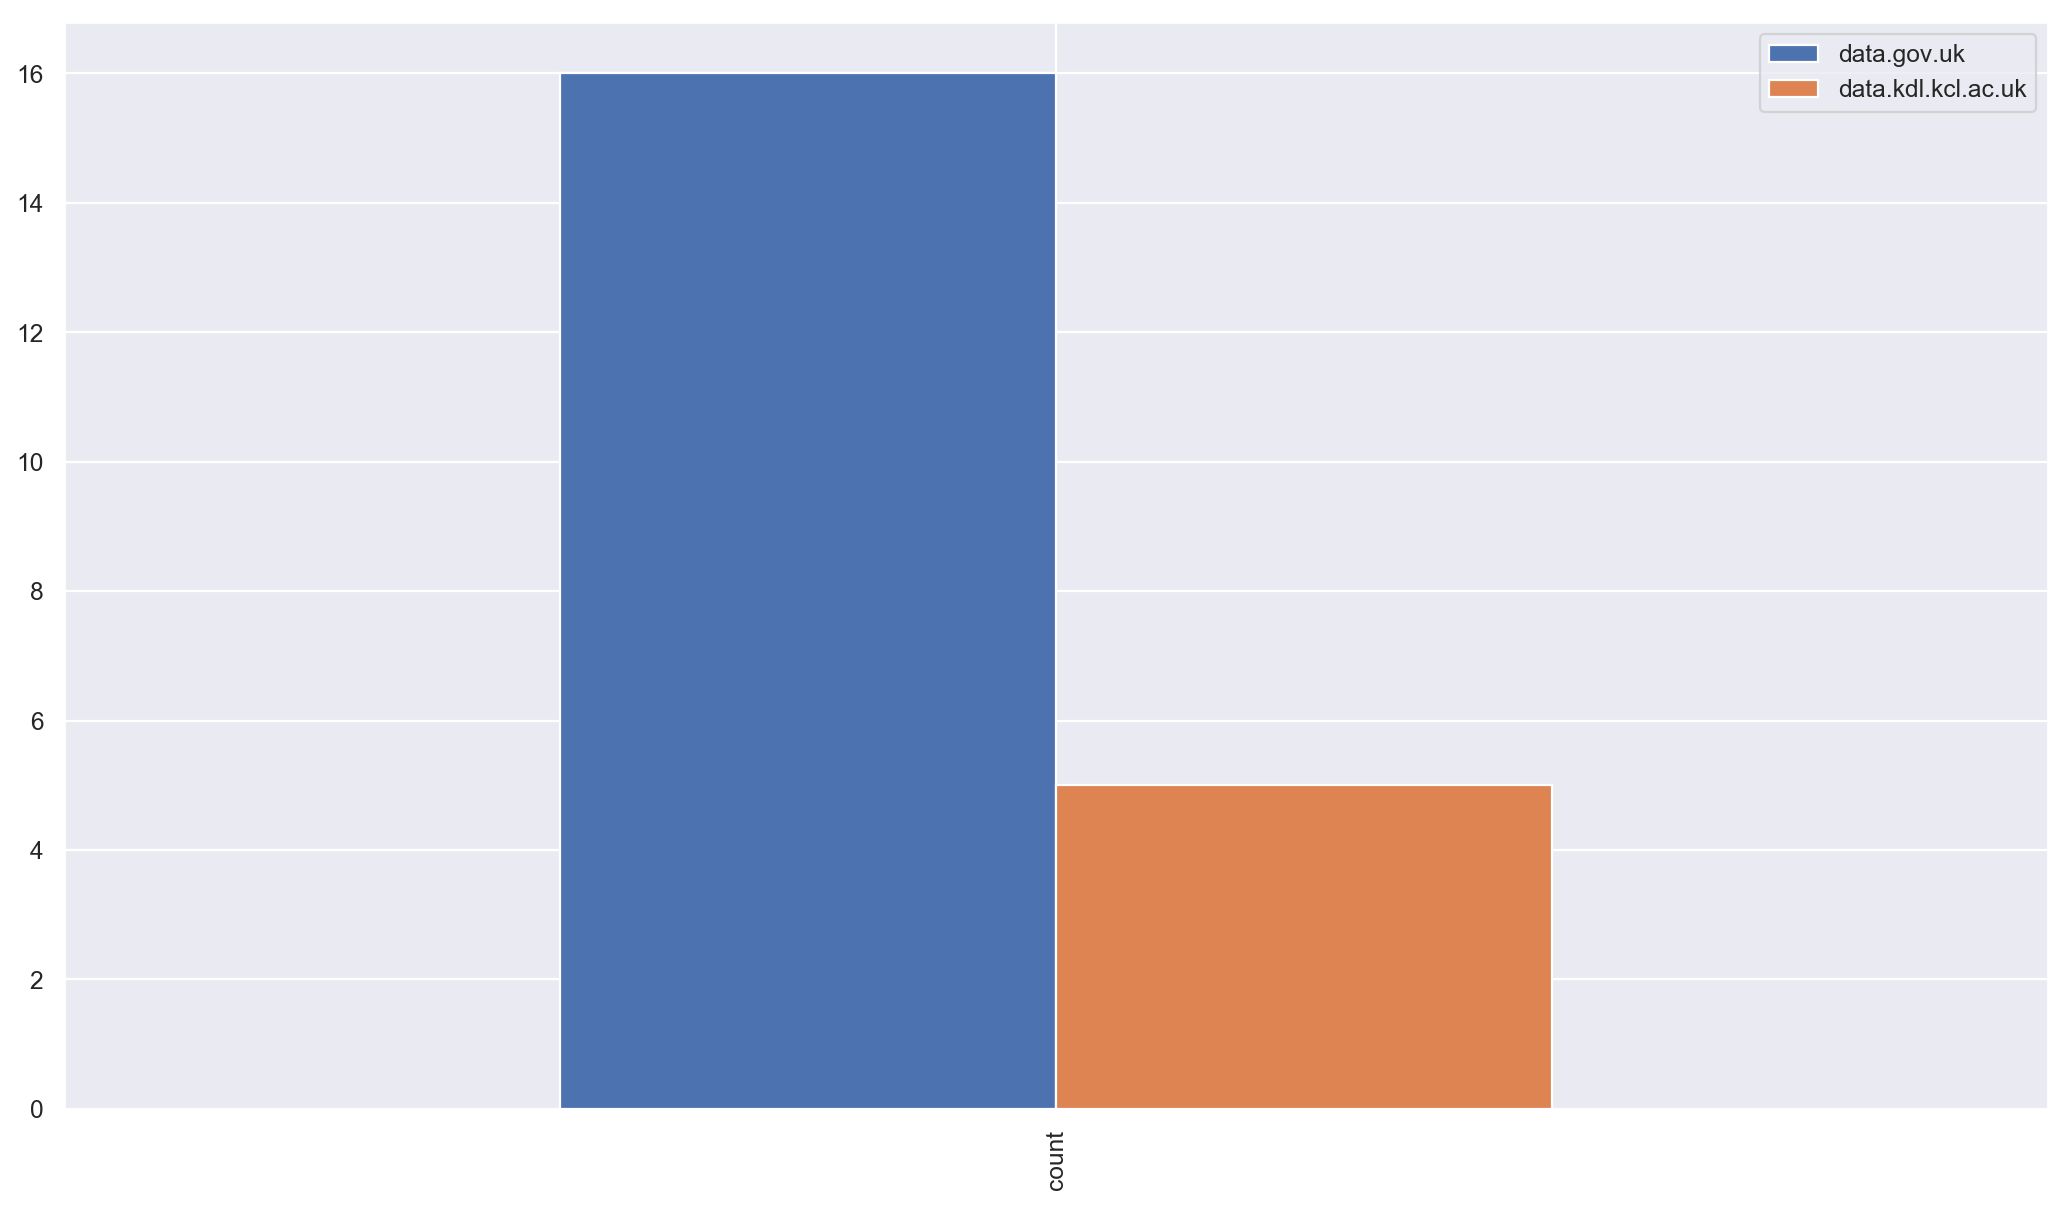

In [55]:
exts_df.describe()[:1].plot.bar()

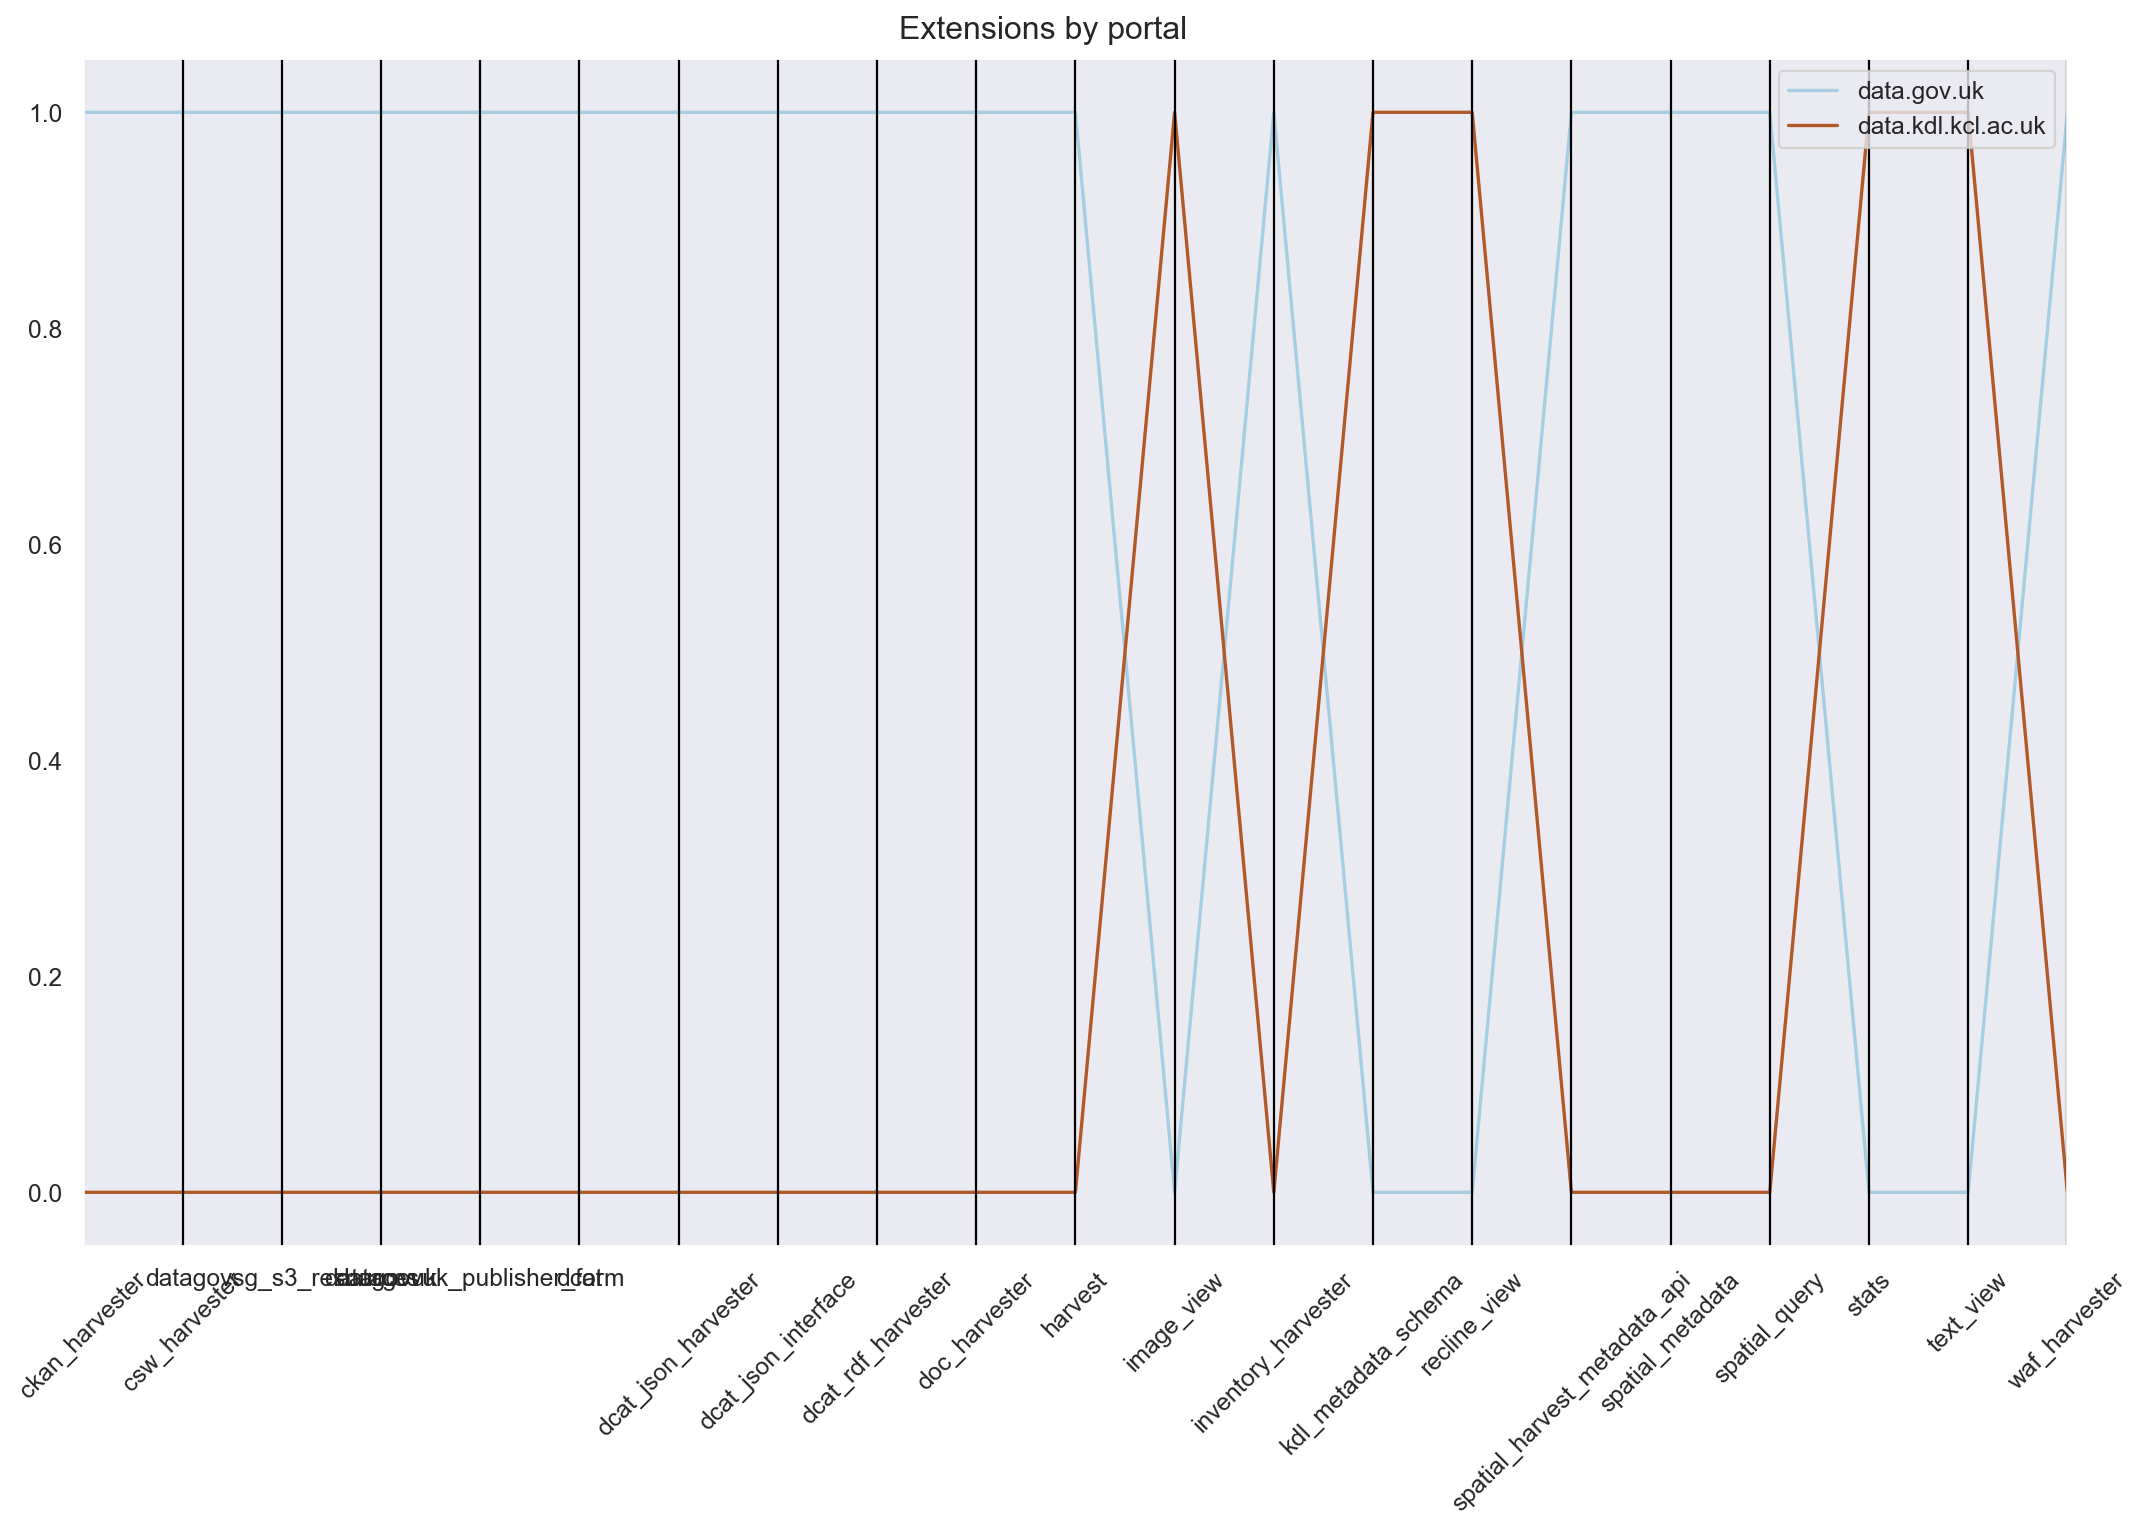

In [56]:
exts_parallel = exts_df.fillna(0)
exts_parallel = exts_parallel.transpose().reset_index()

fig, (ax) = plt.subplots(1, 1, figsize=FIG_SIZE)
fig.subplots_adjust(top=0.95)
fig.suptitle('Extensions by portal')

ax.set_xticklabels(exts_parallel['index'], rotation=45)

pd.plotting.parallel_coordinates(exts_parallel, 'index', colormap='Paired', sort_labels=True)

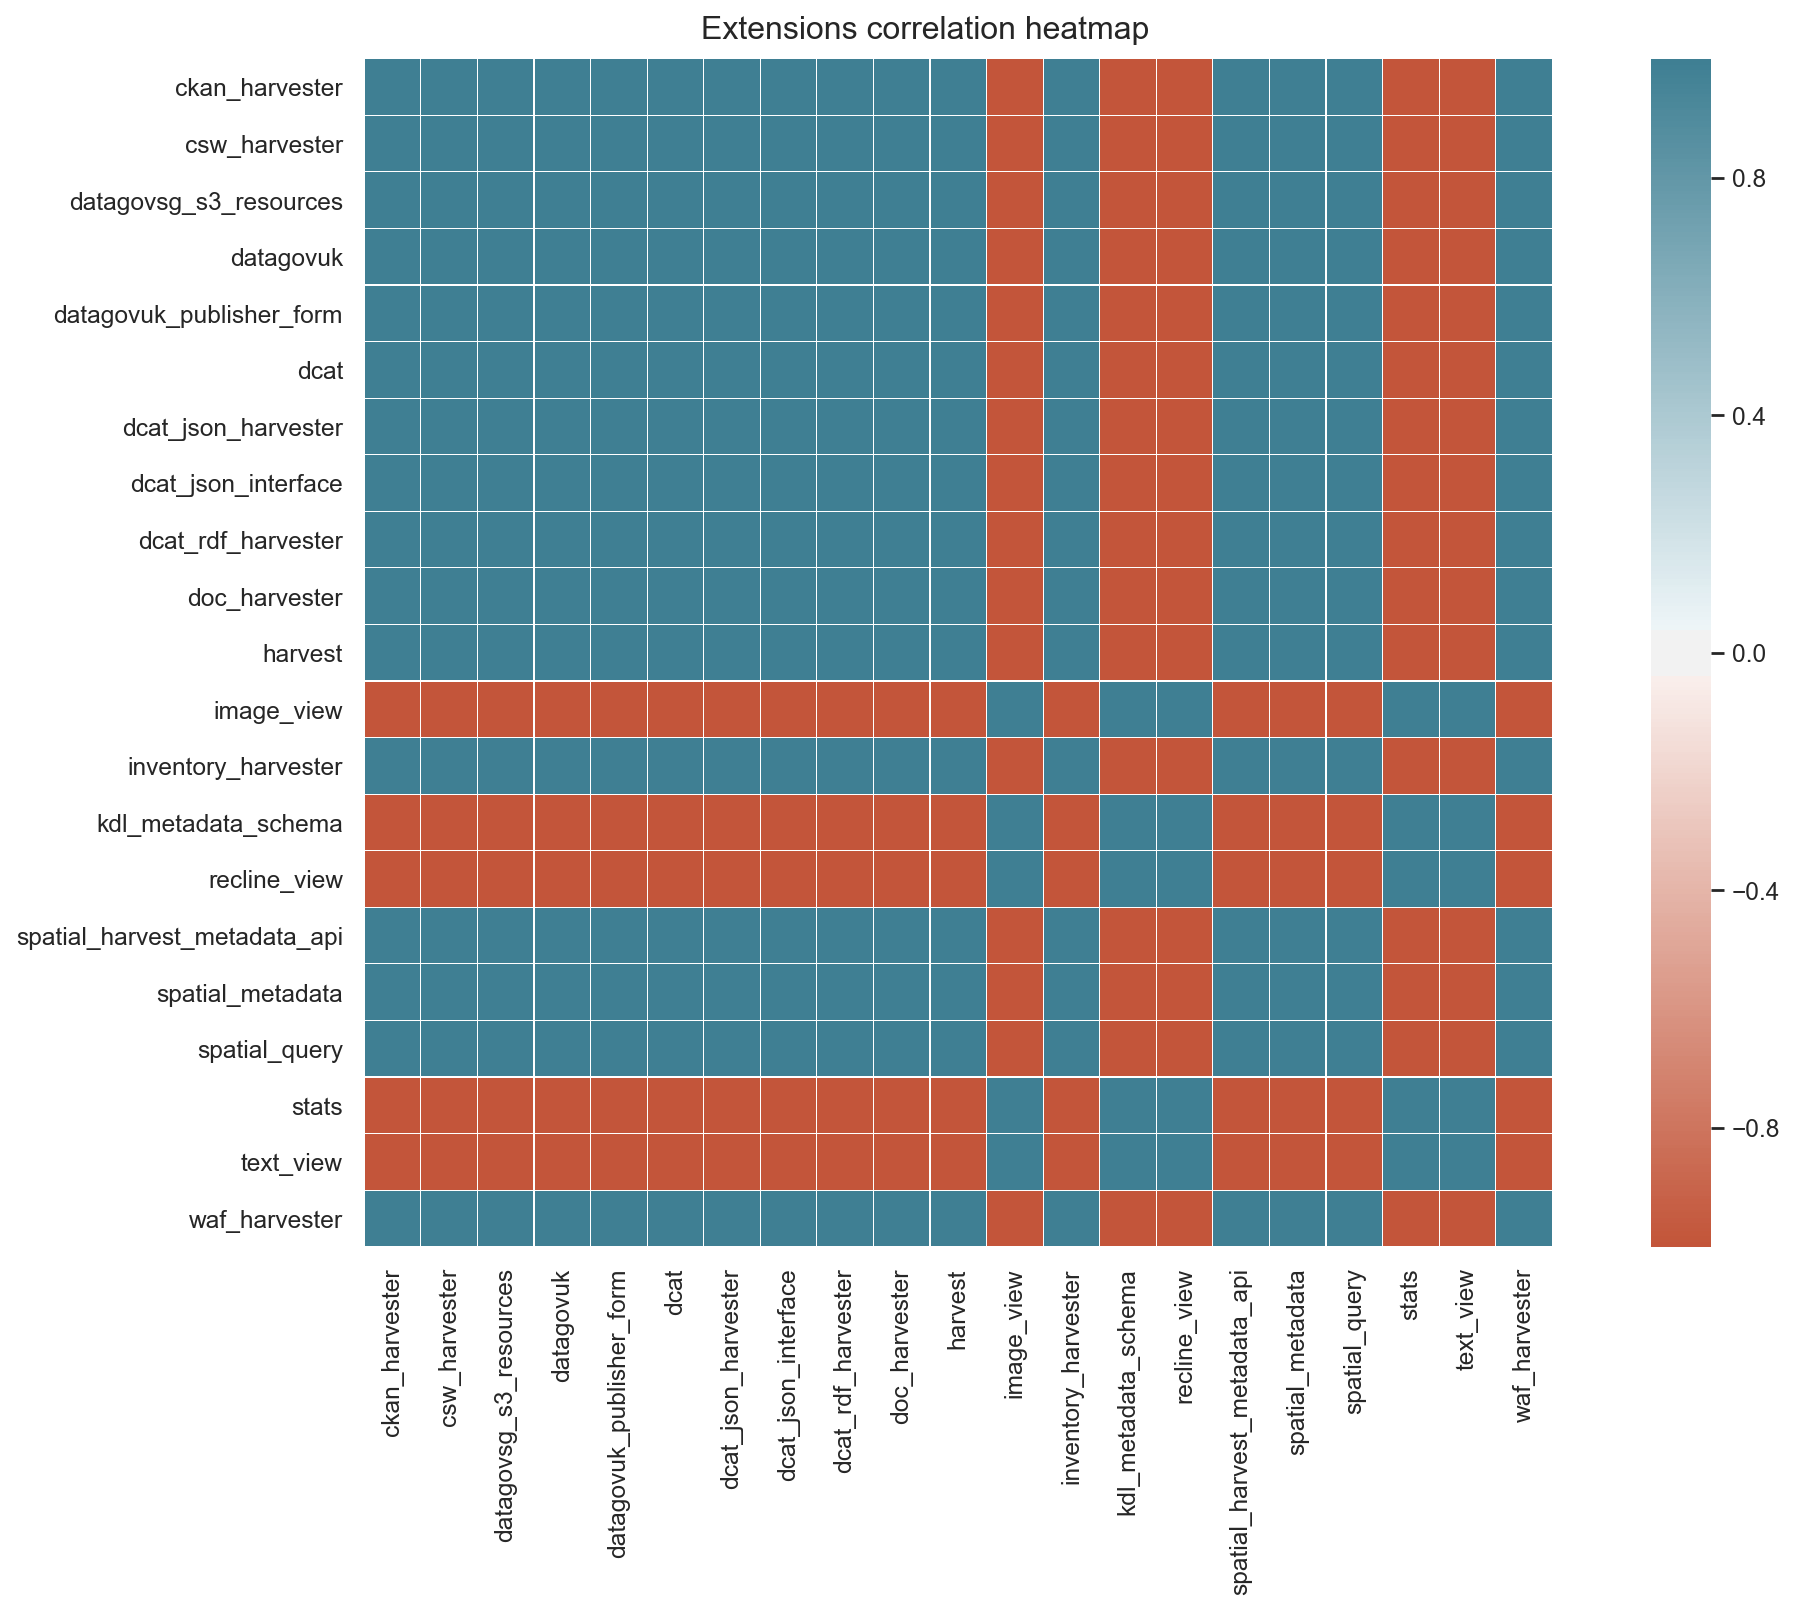

In [60]:
exts_corr = exts_df.fillna(0)
exts_corr = exts_corr.transpose().corr()

fig, (ax) = plt.subplots(1, 1, figsize=FIG_SIZE)
fig.subplots_adjust(top=0.95)
fig.suptitle('Extensions correlation heatmap')

hm = sns.heatmap(exts_corr, ax=ax, cmap=sns.diverging_palette(20, 220, n=exts_corr.size), linewidths=.05, square=True)

### Tags

In [61]:
tags_df.head()

,data.gov.uk,data.kdl.kcl.ac.uk
1200c,2.0,NaN
1991,2.0,NaN
2001,40.0,NaN
2001 census,2.0,NaN
2003,4.0,NaN


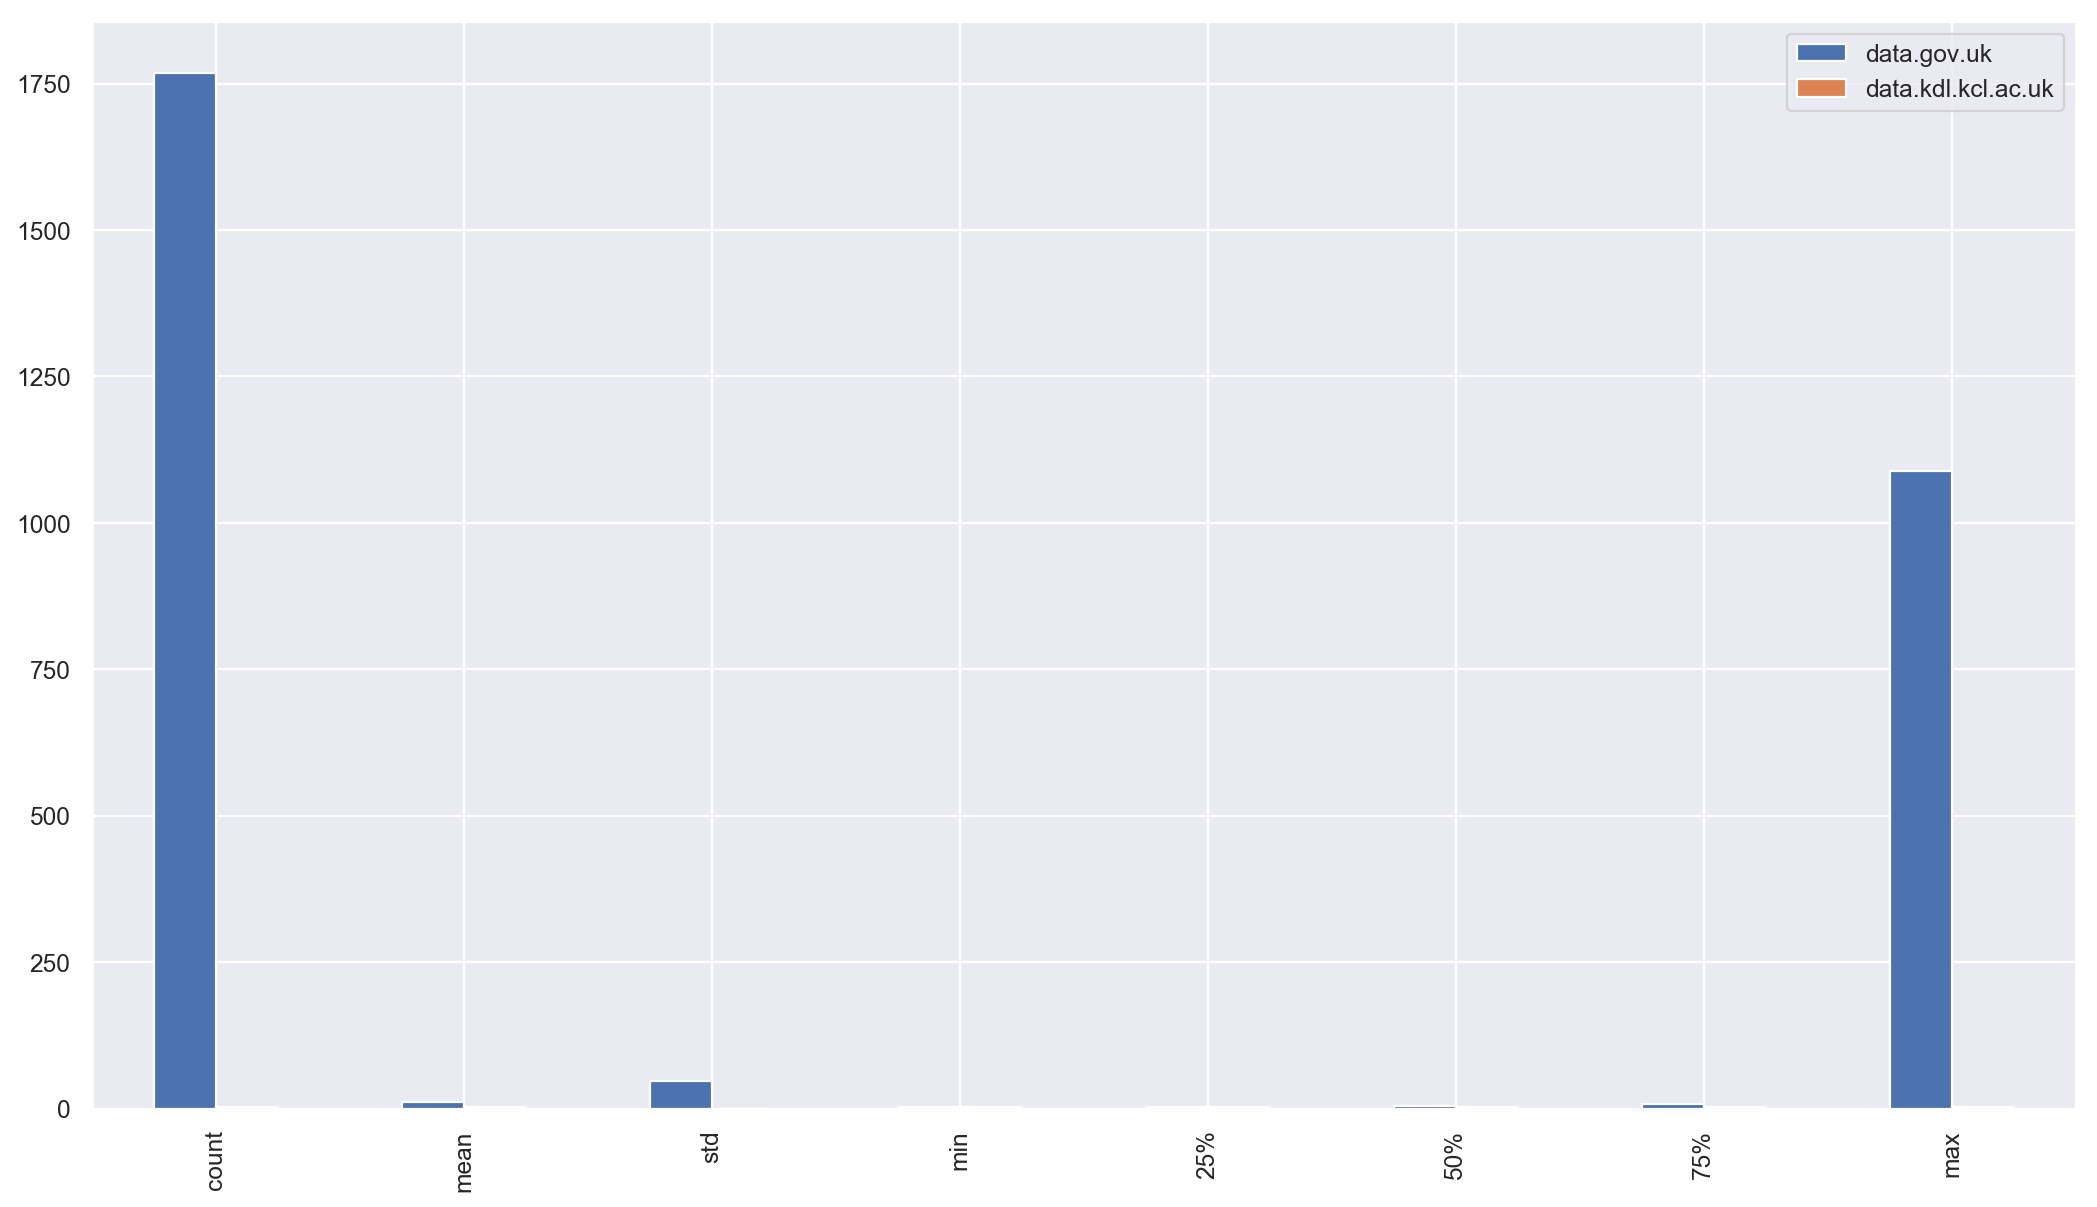

In [62]:
tags_df.describe().plot.bar()

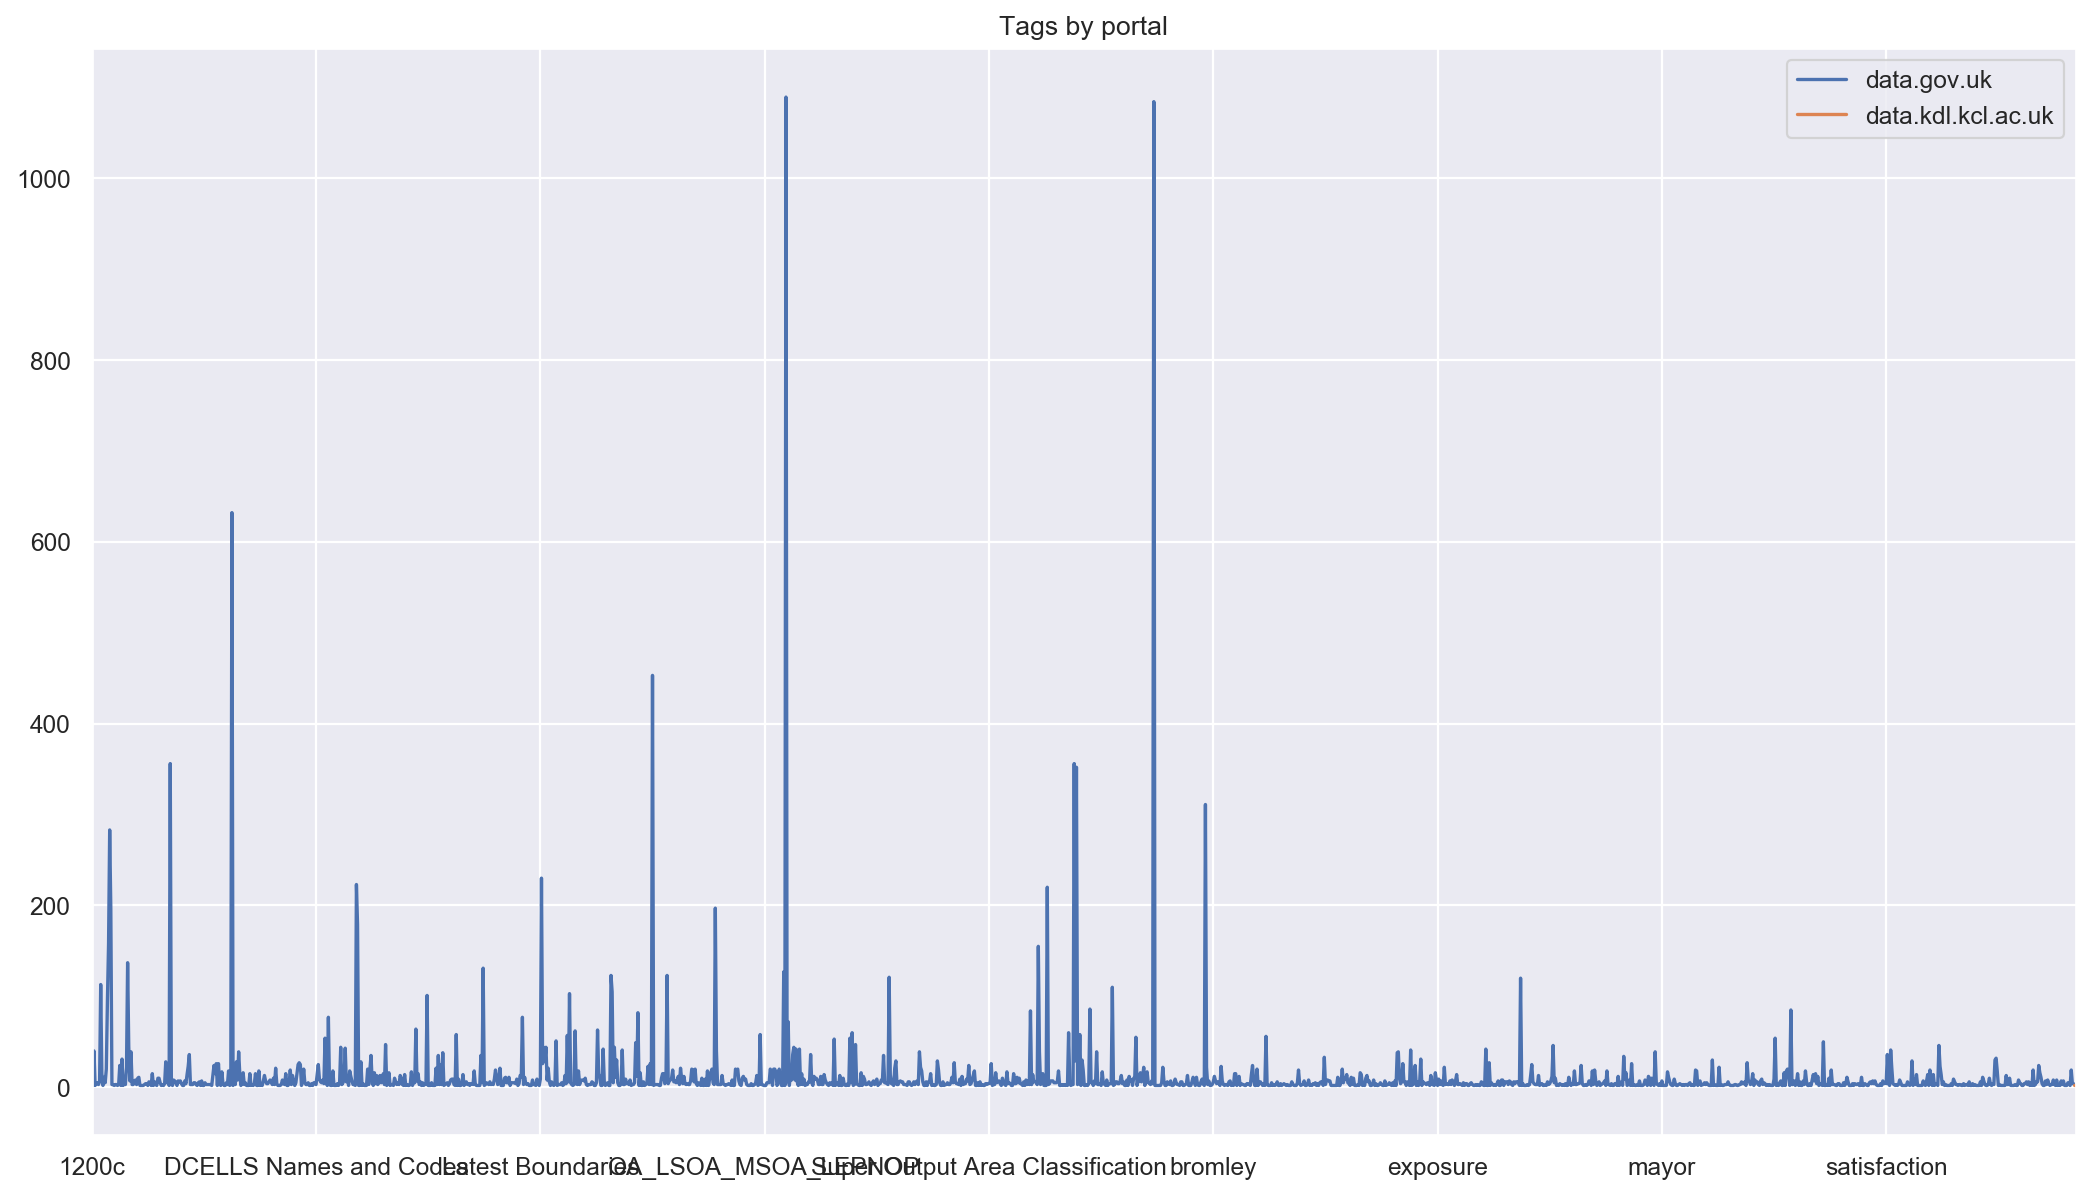

In [63]:
tags_df.plot(title='Tags by portal')

### Themes

In [64]:
themes_df.head()

,data.gov.uk,data.kdl.kcl.ac.uk
business-and-economy,1093.0,NaN
crime-and-justice,705.0,NaN
defence,187.0,NaN
education,1250.0,NaN
environment,12678.0,NaN


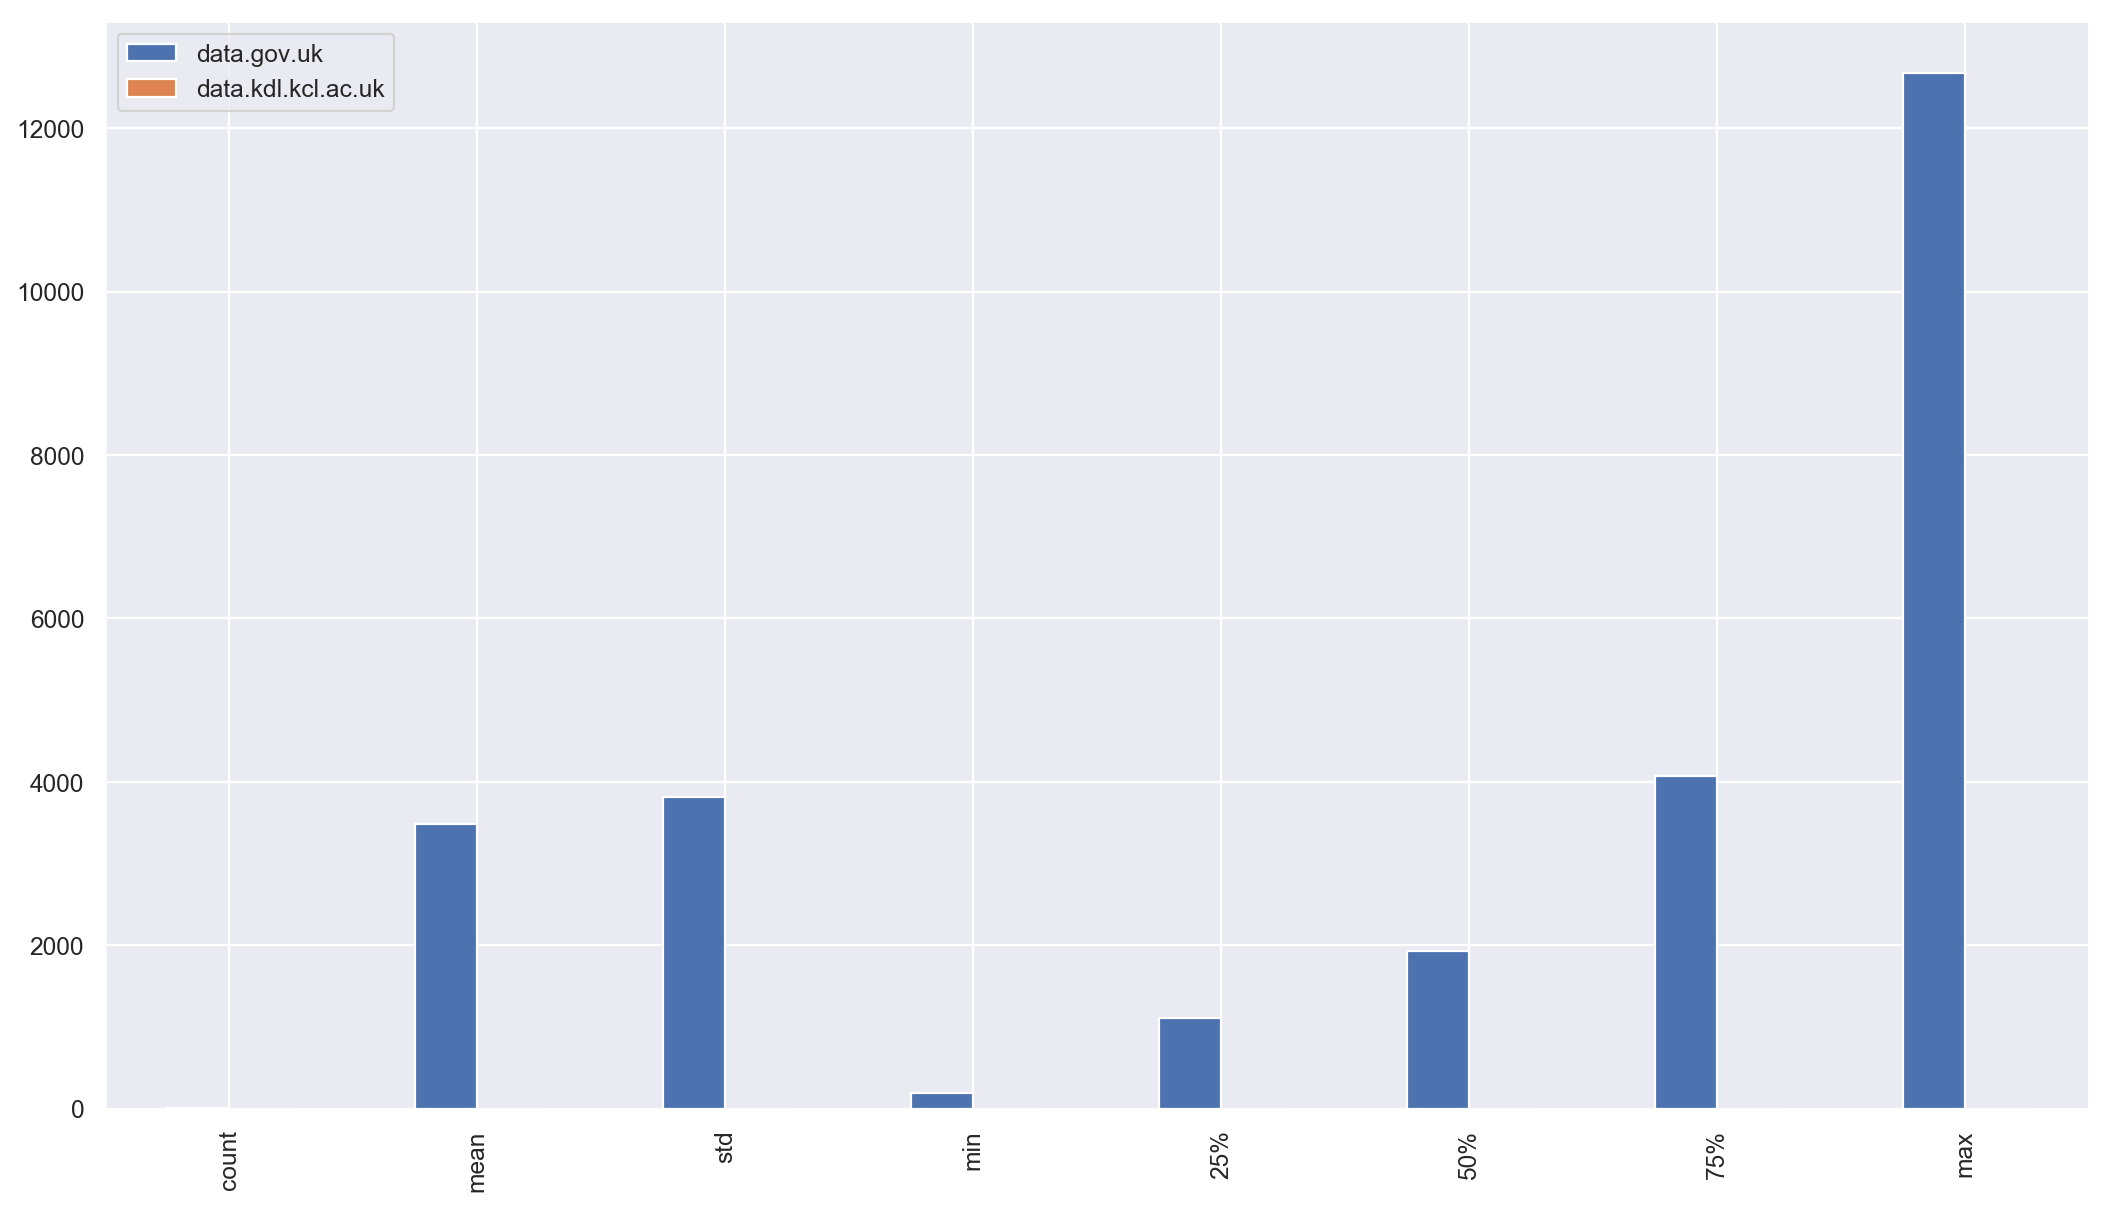

In [67]:
themes_df.describe().plot.bar()

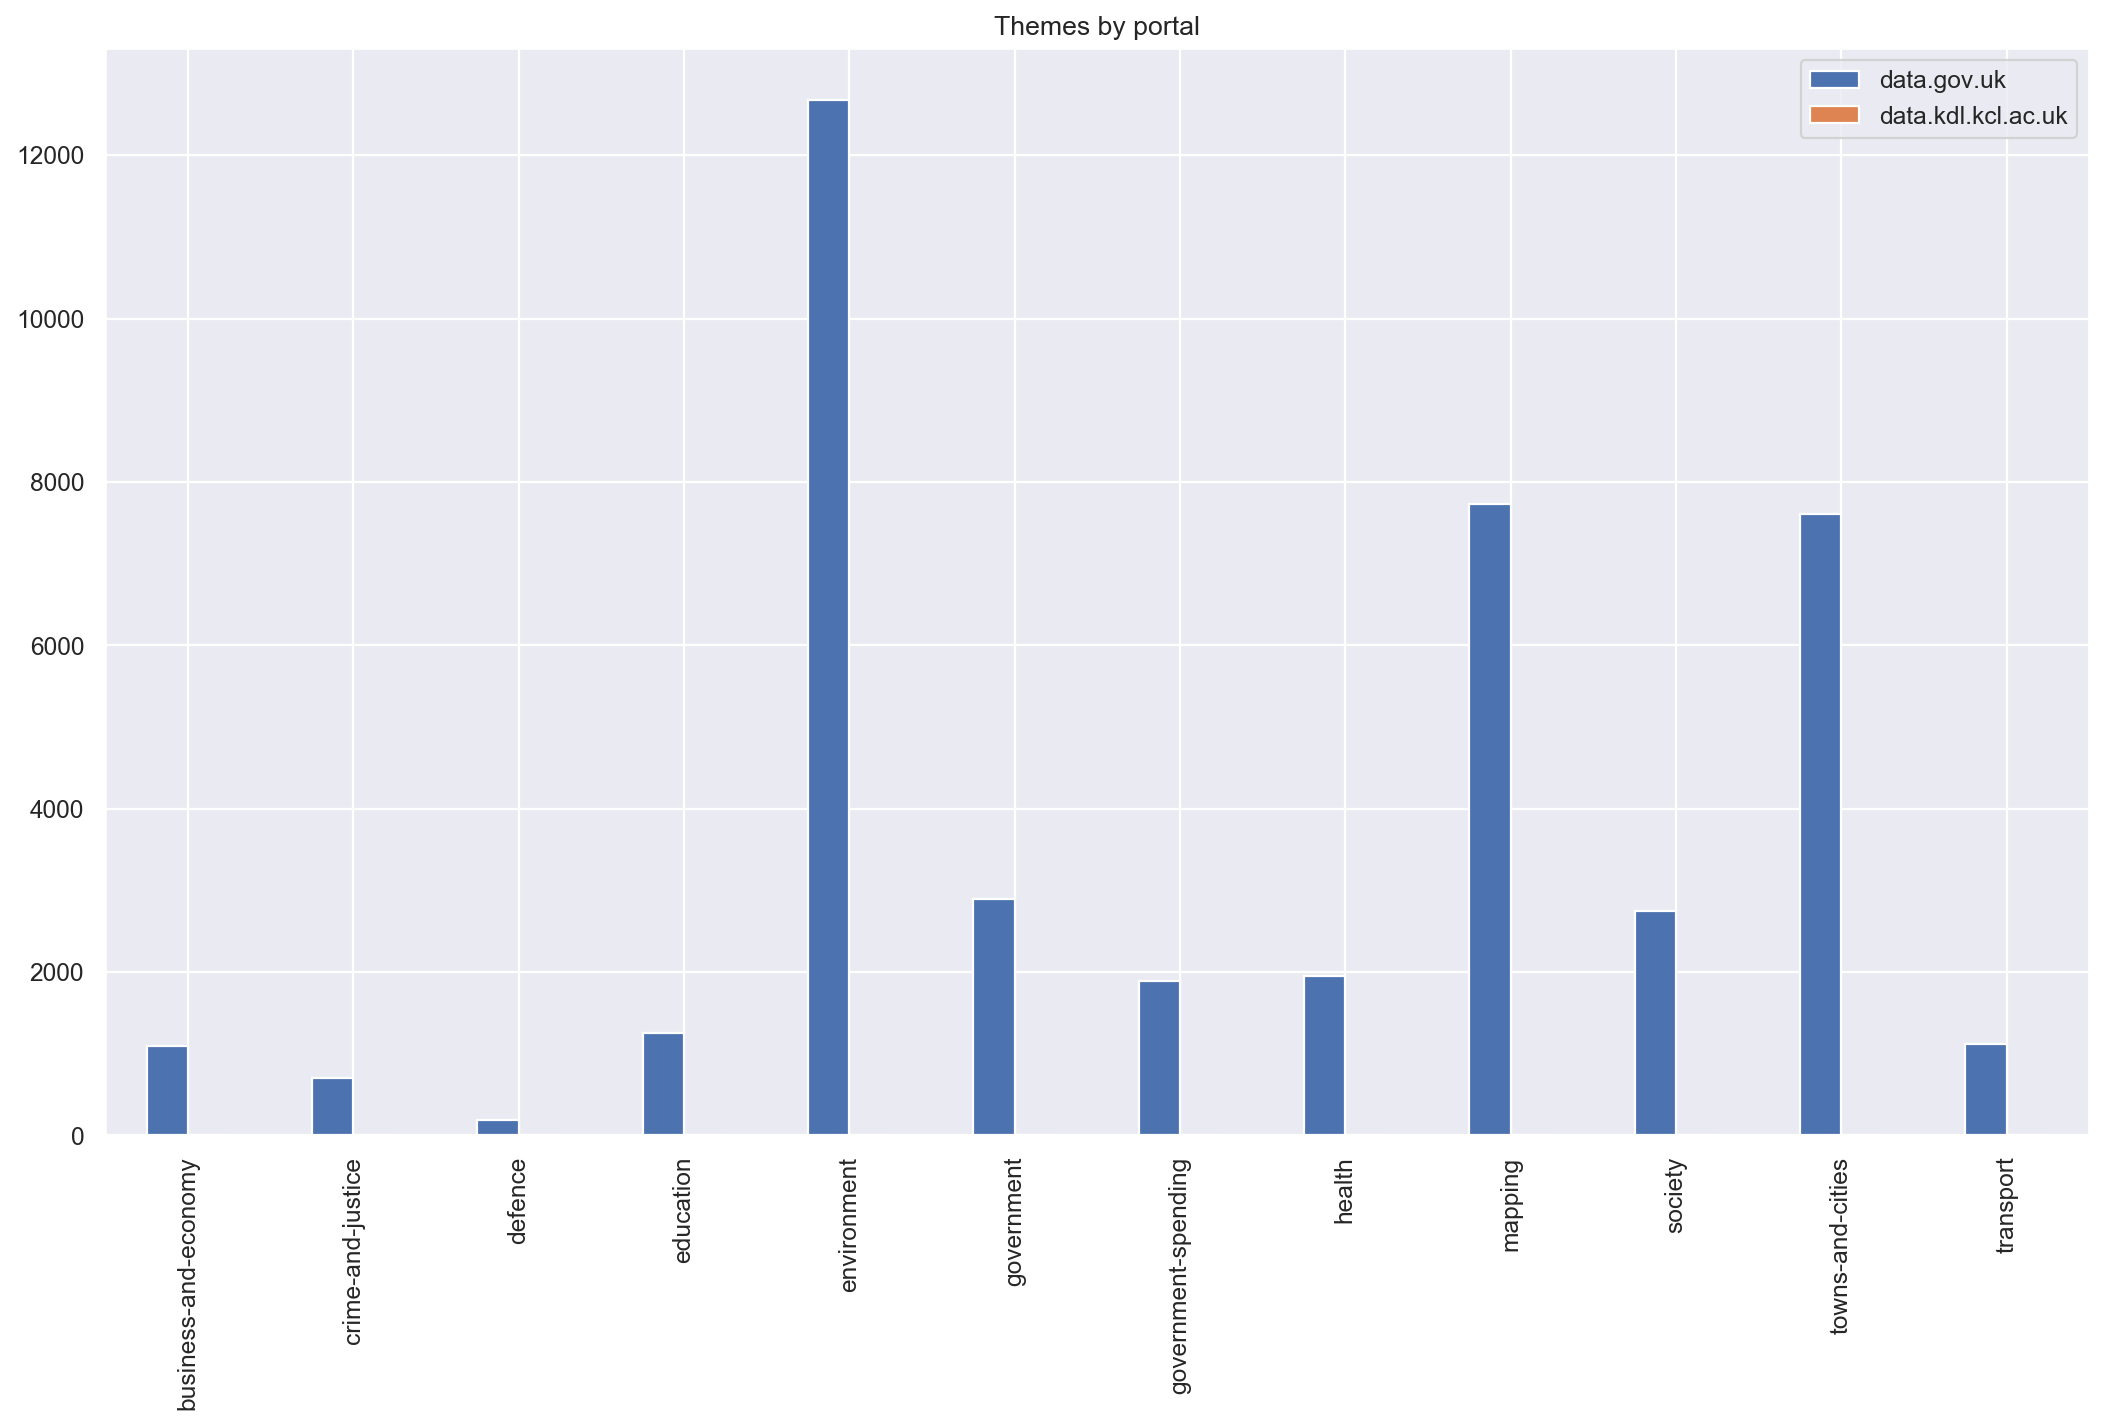

In [68]:
themes_df.plot.bar(title='Themes by portal')